In [1]:
# dataset
from google.cloud import bigquery
from google.oauth2 import service_account

# maths and eda
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

credentials = service_account.Credentials.from_service_account_file('../credentials')
# Initialize the BigQuery client
client = bigquery.Client(credentials=credentials)

# About the dataset

The mushroom dataset is part of the UCI Machine Learning repository.
<br><br>
Despite the appeal of mushroom foraging, gatherers must be cautious, as mushrooms can be poisonous or even deadly.
<br><br>
This project aims to determine what characteristic features of mushrooms cause certain death and which are most edible. Note that all the data in this data set are hypothetical and based on 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom.
<br><br>
<b>Question:</b> Which features are most indicative of a poisonous mushroom?

# 🍄 About Mushrooms 🍄
Before I begin EDA on this data set, it is essential to know the anatomy of a mushroom.

![mushroom anatomy](mushroom_anatomy.jpg)

This datasets contains the following information about <b>caps:</b>
-  cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
-  cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
-  cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

This datasets contains the following information about the <b>gill:</b>
- gill-attachment: attached=a,descending=d,free=f,notched=n
- gill-spacing: close=c,crowded=w,distant=d
- gill-size: broad=b,narrow=n
- gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y

This datasets contains the following information about the <b>stalk:</b>
- stalk-shape: enlarging=e,tapering=t
- stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
- stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
- stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
- stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

This datasets contains the following information about the <b>veil:</b>
- veil-type: partial=p,universal=u
- veil-color: brown=n,orange=o,white=w,yellow=y

This datasets contains the following information about the <b>ring:</b>
- ring-number: none=n,one=o,two=t
- ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z

Additional characteristics:
- spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
- population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
- habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d
- bruises: bruises=t,no=f
- odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

In [2]:
# query data
QUERY = ("""SELECT * FROM `portfoliodata-428314.kaggle.mushrooms`""")
query_job = client.query(QUERY)
mushrooms = query_job.result().to_dataframe()
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,y,e,False,m,f,c,b,w,...,y,c,c,p,w,n,n,w,c,d
1,p,k,y,c,False,m,a,c,b,w,...,y,c,c,p,w,n,n,w,c,d
2,p,k,y,n,False,m,f,c,b,w,...,y,c,c,p,w,n,n,w,c,d
3,p,f,y,e,False,m,a,c,b,w,...,y,c,c,p,w,n,n,w,c,d
4,p,k,y,e,False,m,f,c,b,y,...,y,c,c,p,w,n,n,w,c,d


# EDA

In [3]:
# mushrooms_profile = ProfileReport(mushrooms, title="Report")
# mushrooms_profile

# Feature Engineering & Data Cleanse

In [4]:
# edible=e, poisonous=p
mushrooms['class'] = mushrooms['class'].map({'e':'0','p':'1'})
mushrooms['class']=mushrooms['class'].astype(int)

In [5]:
# all the mushrooms in this dataset have a partial veil. remove from dataset
mushrooms=mushrooms.drop('veil-type',axis=1)

In [6]:
# there are three variables that are imbalanced: gill-attachment, veil-color, and ring-number

# create a new feature to reduce imbalance
mushrooms['gill-attachment-color']=mushrooms['gill-attachment']+"_"+mushrooms['gill-color']
mushrooms=mushrooms.drop('gill-attachment',axis=1)
mushrooms['gill-attachment-color'].value_counts()

gill-attachment-color
f_b    1728
f_p    1492
f_w    1193
f_n     984
f_g     752
f_h     732
f_u     492
f_k     408
f_e      96
a_y      73
a_o      64
a_n      64
f_r      24
f_y      13
a_w       9
Name: count, dtype: int64

In [7]:
mushrooms=mushrooms.drop('veil-color',axis=1)

In [8]:
# create a new feature to reduce imbalance
mushrooms['ring_number_type']=mushrooms['ring-number']+"_"+mushrooms['ring-type']
mushrooms=mushrooms.drop('ring-number',axis=1)
mushrooms['ring_number_type'].value_counts()

ring_number_type
o_p    3560
o_e    2584
o_l    1296
t_p     408
t_e     192
o_f      48
n_n      36
Name: count, dtype: int64

In [9]:
# is the gill color the same as the cap color?
mushrooms['gill-cap-color']=np.where(mushrooms["gill-color"]==mushrooms["cap-color"],"same","different")
mushrooms['gill-cap-color'].value_counts()

gill-cap-color
different    7224
same          900
Name: count, dtype: int64

In [10]:
# new field for stalk color
mushrooms['stalk-color-above-below-ring']=np.where(mushrooms["stalk-color-above-ring"]==mushrooms["stalk-color-below-ring"],"same","different")
mushrooms['stalk-color-above-below-ring'].value_counts()

stalk-color-above-below-ring
same         5068
different    3056
Name: count, dtype: int64

In [11]:
# is the cap color different than the stalk?
mushrooms['stalk-ring-color-cap-color']=np.where((mushrooms["stalk-color-above-ring"]==mushrooms["cap-color"]) & (mushrooms["stalk-color-below-ring"]!=mushrooms["cap-color"]),"same_above_ring",
                                                 np.where((mushrooms["stalk-color-below-ring"]==mushrooms["cap-color"]) & (mushrooms["stalk-color-above-ring"]!=mushrooms["cap-color"]),"same_below_ring",
                                                 np.where((mushrooms["stalk-color-above-ring"]==mushrooms["cap-color"]) & (mushrooms["stalk-color-below-ring"]==mushrooms["cap-color"]),"same_above_below_ring",
                                                 "different"))
                                                )
mushrooms['stalk-ring-color-cap-color'].value_counts()

stalk-ring-color-cap-color
different                6652
same_above_below_ring    1152
same_below_ring           180
same_above_ring           140
Name: count, dtype: int64

In [12]:
# is there red in the cap or stalk
mushrooms['red']=np.where((mushrooms["cap-color"]=="e") | (mushrooms["stalk-color-above-ring"]=="e") | (mushrooms["stalk-color-below-ring"]=="e"),"y","n")
mushrooms['red'].value_counts()

red
n    6516
y    1608
Name: count, dtype: int64

In [13]:
mushrooms=mushrooms.drop(["stalk-color-below-ring","stalk-color-above-ring"],axis=1)

In [14]:
# is there white on the gill?
mushrooms['white-gill']=np.where(mushrooms["gill-color"]=="w","y","n")
mushrooms=mushrooms.drop("gill-color",axis=1)
mushrooms['white-gill'].value_counts()

white-gill
n    6922
y    1202
Name: count, dtype: int64

# Random Forest

In [35]:
X = mushrooms.drop('class', axis=1)
y = mushrooms['class']

# this dataset only contains categorical features
categorical_pipeline = Pipeline([('encoding', OneHotEncoder(drop='first', sparse_output=False))])
data_pipeline = ColumnTransformer([('categorical', categorical_pipeline, X.columns)])

# 20% out of bag test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


pipeline = Pipeline(steps=[('data_pipeline', data_pipeline),('rf', RandomForestClassifier(max_depth=3))])

pipeline.fit(X_train, y_train)

# evaluate the model on the out of bag test dataset
y_pred = pipeline.predict(X_test)

# metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f} Precision: {precision:.4f} Recall: {recall:.4f}")

Accuracy: 0.9512 Precision: 0.9553443275932688 Recall: 0.9511894995898277


In [36]:
# check to make sure we are not overfitting the model
print(f"Training set accuracy: {pipeline.score(X_train, y_train):.4f}")

Training set accuracy: 0.9520


In [29]:
data = {
    'name': [
        'cap-shape', 'cap-shape', 'cap-shape', 'cap-shape', 'cap-shape', 'cap-shape',
        'cap-surface', 'cap-surface', 'cap-surface', 'cap-surface',
        'cap-color', 'cap-color', 'cap-color', 'cap-color', 'cap-color', 'cap-color', 'cap-color', 'cap-color', 'cap-color', 'cap-color',
        'gill-attachment', 'gill-attachment', 'gill-attachment', 'gill-attachment',
        'gill-spacing', 'gill-spacing', 'gill-spacing',
        'gill-size', 'gill-size',
        'gill-color', 'gill-color', 'gill-color', 'gill-color', 'gill-color', 'gill-color', 'gill-color', 'gill-color', 'gill-color', 'gill-color', 'gill-color', 'gill-color',
        'stalk-shape', 'stalk-shape',
        'stalk-root', 'stalk-root', 'stalk-root', 'stalk-root', 'stalk-root', 'stalk-root', 'stalk-root',
        'stalk-surface-above-ring', 'stalk-surface-above-ring', 'stalk-surface-above-ring', 'stalk-surface-above-ring',
        'stalk-surface-below-ring', 'stalk-surface-below-ring', 'stalk-surface-below-ring', 'stalk-surface-below-ring',
        'stalk-color-above-ring', 'stalk-color-above-ring', 'stalk-color-above-ring', 'stalk-color-above-ring', 'stalk-color-above-ring', 'stalk-color-above-ring', 'stalk-color-above-ring', 'stalk-color-above-ring', 'stalk-color-above-ring',
        'stalk-color-below-ring', 'stalk-color-below-ring', 'stalk-color-below-ring', 'stalk-color-below-ring', 'stalk-color-below-ring', 'stalk-color-below-ring', 'stalk-color-below-ring', 'stalk-color-below-ring', 'stalk-color-below-ring',
        'veil-type', 'veil-type',
        'veil-color', 'veil-color', 'veil-color', 'veil-color',
        'ring-number', 'ring-number', 'ring-number',
        'ring-type', 'ring-type', 'ring-type', 'ring-type', 'ring-type', 'ring-type', 'ring-type', 'ring-type',
        'spore-print-color', 'spore-print-color', 'spore-print-color', 'spore-print-color', 'spore-print-color', 'spore-print-color', 'spore-print-color', 'spore-print-color', 'spore-print-color',
        'population', 'population', 'population', 'population', 'population', 'population',
        'habitat', 'habitat', 'habitat', 'habitat', 'habitat', 'habitat', 'habitat',
        'bruises', 'bruises',
        'odor', 'odor', 'odor', 'odor', 'odor', 'odor', 'odor', 'odor', 'odor'
    ],
    'value': [
        'b', 'c', 'x', 'f', 'k', 's',
        'f', 'g', 'y', 's',
        'n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y',
        'a', 'd', 'f', 'n',
        'c', 'w', 'd',
        'b', 'n',
        'k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y',
        'e', 't',
        'b', 'c', 'u', 'e', 'z', 'r', '?',
        'f', 'y', 'k', 's',
        'f', 'y', 'k', 's',
        'n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y',
        'n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y',
        'p', 'u',
        'n', 'o', 'w', 'y',
        'n', 'o', 't',
        'c', 'e', 'f', 'l', 'n', 'p', 's', 'z',
        'k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y',
        'a', 'c', 'n', 's', 'v', 'y',
        'g', 'l', 'm', 'p', 'u', 'w', 'd',
        't', 'f',
        'a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's'
    ],
    'description': [
        'bell', 'conical', 'convex', 'flat', 'knobbed', 'sunken',
        'fibrous', 'grooves', 'scaly', 'smooth',
        'brown', 'buff', 'cinnamon', 'gray', 'green', 'pink', 'purple', 'red', 'white', 'yellow',
        'attached', 'descending', 'free', 'notched',
        'close', 'crowded', 'distant',
        'broad', 'narrow',
        'black', 'brown', 'buff', 'chocolate', 'gray', 'green', 'orange', 'pink', 'purple', 'red', 'white', 'yellow',
        'enlarging', 'tapering',
        'bulbous', 'club', 'cup', 'equal', 'rhizomorphs', 'rooted', 'missing',
        'fibrous', 'scaly', 'silky', 'smooth',
        'fibrous', 'scaly', 'silky', 'smooth',
        'brown', 'buff', 'cinnamon', 'gray', 'orange', 'pink', 'red', 'white', 'yellow',
        'brown', 'buff', 'cinnamon', 'gray', 'orange', 'pink', 'red', 'white', 'yellow',
        'partial', 'universal',
        'brown', 'orange', 'white', 'yellow',
        'none', 'one', 'two',
        'cobwebby', 'evanescent', 'flaring', 'large', 'none', 'pendant', 'sheathing', 'zone',
        'black', 'brown', 'buff', 'chocolate', 'green', 'orange', 'purple', 'white', 'yellow',
        'abundant', 'clustered', 'numerous', 'scattered', 'several', 'solitary',
        'grasses', 'leaves', 'meadows', 'paths', 'urban', 'waste', 'woods',
        'bruises', 'no',
        'almond', 'anise', 'creosote', 'fishy', 'foul', 'musty', 'none', 'pungent', 'spicy'
    ]
}

data_codes = pd.DataFrame(data)

In [30]:
# Combine the feature importances from the model and feature names from the training data
feature_importances = pd.DataFrame(data={'feature_name_value':data_pipeline.get_feature_names_out(),
                                         'importance':pipeline['rf'].feature_importances_}
                                )
feature_importances['feature_name_value']=feature_importances.feature_name_value.str.replace('categorical__','')
feature_importances[['name', 'value']] = feature_importances['feature_name_value'].str.split('_', n=1, expand=True)
feature_importances=feature_importances.merge(data_codes,how='left')
feature_importances['feature_name_value']=np.where(feature_importances['description'].isna(),feature_importances['feature_name_value'],feature_importances['name']+" : "+feature_importances['description'])

,feature_name_value,importance,name,value,description
0,cap-shape : conical,0.000024,cap-shape,c,conical
1,cap-shape : flat,0.000084,cap-shape,f,flat
2,cap-shape : knobbed,0.000972,cap-shape,k,knobbed
3,cap-shape : sunken,0.000000,cap-shape,s,sunken
4,cap-shape : convex,0.000003,cap-shape,x,convex
...,...,...,...,...,...
84,stalk-ring-color-cap-color_same_above_below_ring,0.001971,stalk-ring-color-cap-color,same_above_below_ring,NaN
85,stalk-ring-color-cap-color_same_above_ring,0.000000,stalk-ring-color-cap-color,same_above_ring,NaN
86,stalk-ring-color-cap-color_same_below_ring,0.000000,stalk-ring-color-cap-color,same_below_ring,NaN
87,red_y,0.001201,red,y,NaN


In [31]:
top_feats=feature_importances[['feature_name_value','importance']].sort_values(by='importance',ascending=False).head(10)
bottom_feats=feature_importances[['feature_name_value','importance']].sort_values(by='importance',ascending=True).head(10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


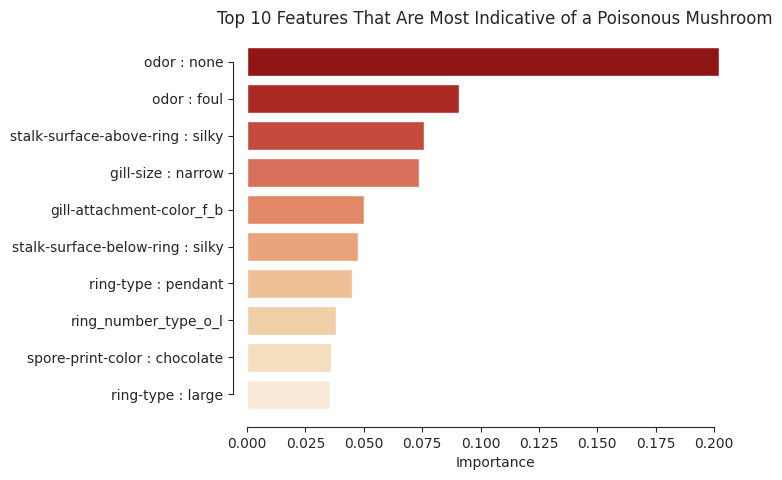

In [32]:
sns.set_style("ticks")
ax=sns.barplot(data=top_feats,x='importance', y='feature_name_value', errorbar=None,palette='OrRd_r')
plt.title('Top 10 Features That Are Most Indicative of a Poisonous Mushroom',y=1.03)
plt.xlabel('Importance')
plt.ylabel('')
plt.legend(title='Group')
sns.despine(offset=10, trim=True)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, .95), ncol=5, title=None, frameon=False)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


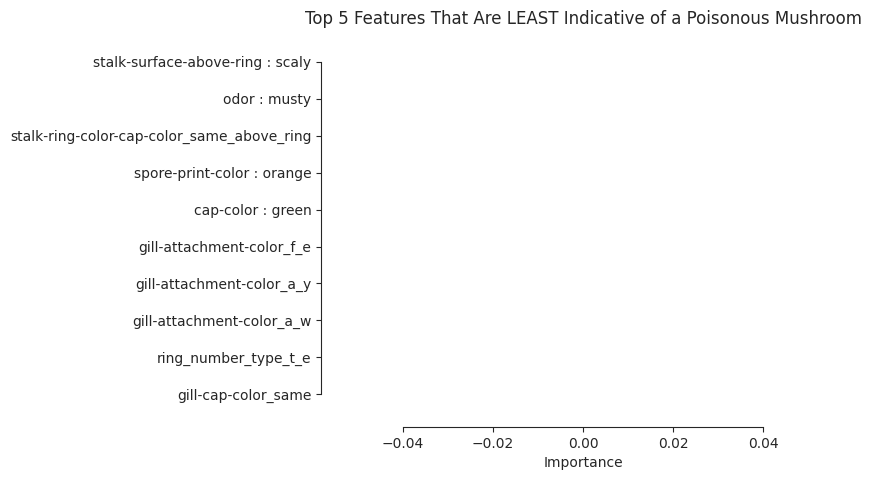

In [33]:
sns.set_style("ticks")
ax=sns.barplot(data=bottom_feats,x='importance', y='feature_name_value', errorbar=None,palette='GnBu_r')
plt.title('Top 5 Features That Are LEAST Indicative of a Poisonous Mushroom',y=1.03)
plt.xlabel('Importance')
plt.ylabel('')
plt.legend(title='Group')
sns.despine(offset=10, trim=True)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, .95), ncol=5, title=None, frameon=False)
plt.show()